In [4]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB+Compass&directConnection=true&ssl=false')
filter={}
collection = client['intelliinvest']['stock-data']
bheldata = []
data = collection.find({'Stock': {"$eq" : 'BHEL'}},{'_id':0, 'Date':1, 'Close':1})
bheldata = [d for d in data]


In [132]:
import pandas as pd

df = pd.DataFrame(bheldata)
df.head()

,Date,Close
0,2020-04-01,20.70
1,2020-04-03,20.65
2,2020-04-07,21.30
3,2020-04-08,21.25
4,2020-04-09,22.35


In [133]:
df.index = df.Date

In [134]:
df = df.drop('Date',axis=1)
df

,Close
Date,
2020-04-01,20.70
2020-04-03,20.65
2020-04-07,21.30
2020-04-08,21.25
2020-04-09,22.35
...,...
2021-09-13,55.15
2021-09-14,58.00
2021-09-15,57.90


In [13]:
df.size

363

In [14]:
df['2020-05']

,Close
Date,
2020-05-04,23.50
2020-05-05,22.90
2020-05-06,23.00
2020-05-07,23.05
2020-05-08,22.20
2020-05-11,22.55
2020-05-12,21.50
2020-05-13,26.60
2020-05-14,27.45


In [112]:
df.describe()

,Close
count,363.000000
mean,42.907163
std,14.596991
min,20.650000
25%,31.375000
50%,38.750000
75%,54.150000
max,77.000000


## Feature engineering

In [25]:
datetimefeatures = pd.DataFrame()
datetimefeatures['month'] = [df.index[i].month for i in range(len(df))]
datetimefeatures['day'] = [df.index[i].day for i in range(len(df))]
datetimefeatures['Close'] = [df.Close[i] for i in range(len(df))]
print(datetimefeatures.head(5))

   month  day  Close
0      4    1  20.70
1      4    3  20.65
2      4    7  21.30
3      4    8  21.25
4      4    9  22.35


In [32]:
temp = df
lagfeatures = pd.concat([temp.shift(1), temp], axis=1)
lagfeatures.columns = ['t', 't+1']
print(lagfeatures.head(5))

                t    t+1
Date                    
2020-04-01    NaN  20.70
2020-04-03  20.70  20.65
2020-04-07  20.65  21.30
2020-04-08  21.30  21.25
2020-04-09  21.25  22.35


In [33]:
lagfeatures = pd.concat([temp.shift(3),temp.shift(2),temp.shift(1), temp], axis=1)
lagfeatures.columns = ['t-2','t-1','t', 't+1']
print(lagfeatures.head(5))

              t-2    t-1      t    t+1
Date                                  
2020-04-01    NaN    NaN    NaN  20.70
2020-04-03    NaN    NaN  20.70  20.65
2020-04-07    NaN  20.70  20.65  21.30
2020-04-08  20.70  20.65  21.30  21.25
2020-04-09  20.65  21.30  21.25  22.35


In [36]:
shifted = temp.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
windowfeatures = pd.concat([means, temp], axis=1)
windowfeatures.columns = ['mean(t-1,t)', 't+1']
print(windowfeatures.head(5))

            mean(t-1,t)    t+1
Date                          
2020-04-01          NaN  20.70
2020-04-03          NaN  20.65
2020-04-07       20.675  21.30
2020-04-08       20.975  21.25
2020-04-09       21.275  22.35


In [40]:
width = 3
shifted = temp.shift(width - 1)
window = shifted.rolling(window=width)
windowsummary = pd.concat([window.min(), window.mean(), window.max(), temp], axis=1)
windowsummary.columns = ['min', 'mean', 'max', 't+1']
print(windowsummary.head(5))

              min       mean   max    t+1
Date                                     
2020-04-01    NaN        NaN   NaN  20.70
2020-04-03    NaN        NaN   NaN  20.65
2020-04-07    NaN        NaN   NaN  21.30
2020-04-08    NaN        NaN   NaN  21.25
2020-04-09  20.65  20.883333  21.3  22.35


In [44]:
window = temp.expanding()
expwindow = pd.concat([window.min(), window.mean(), window.max(), temp.shift(-1)], axis=1)
expwindow.columns = ['min', 'mean', 'max', 't+1']
print(expwindow.head(5))

              min       mean    max    t+1
Date                                      
2020-04-01  20.70  20.700000  20.70  20.65
2020-04-03  20.65  20.675000  20.70  21.30
2020-04-07  20.65  20.883333  21.30  21.25
2020-04-08  20.65  20.975000  21.30  22.35
2020-04-09  20.65  21.250000  22.35  22.00


## Visualization

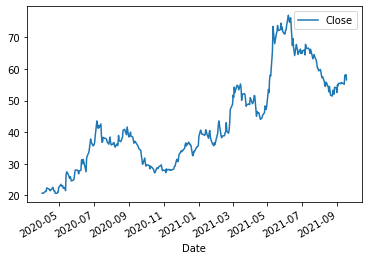

In [113]:
from matplotlib import pyplot

df.plot()
pyplot.show()

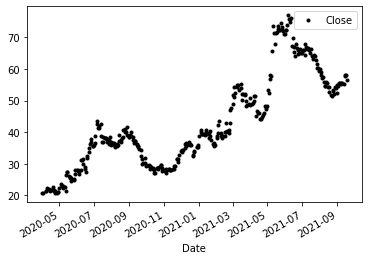

In [114]:
df.plot(style='k.')
pyplot.show()

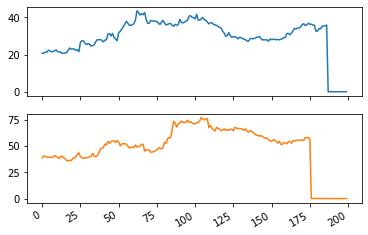

In [115]:
groups = df.Close.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
length = 200
for name, group in groups:
    val = [group.values[i] if i<len(group.values) else 0 for i in range(length)]
    years[name.year] = val
    
years.plot(subplots=True, legend=False)
pyplot.show()

<AxesSubplot:>

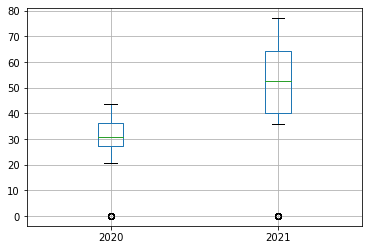

In [116]:
years.boxplot()

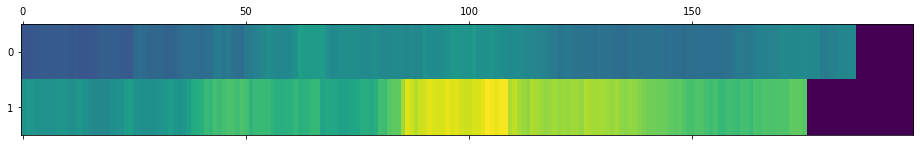

In [117]:
years = years.T
pyplot.matshow(years, interpolation=None, aspect='auto')

<AxesSubplot:>

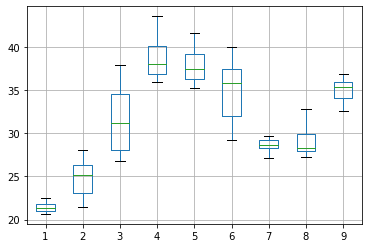

In [118]:
one_year = df['2020']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,10)
months.boxplot()

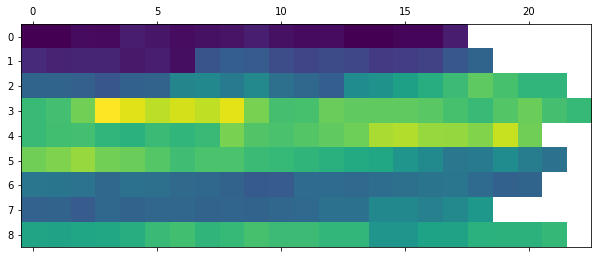

In [119]:
pyplot.matshow(months.T, interpolation=None, aspect='auto')
pyplot.show()

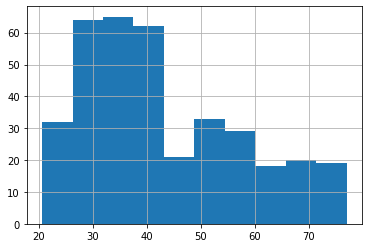

In [120]:
df.Close.hist()
pyplot.show()

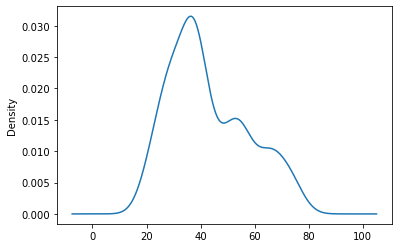

In [121]:
df.Close.plot(kind='kde')
pyplot.show()

<AxesSubplot:>

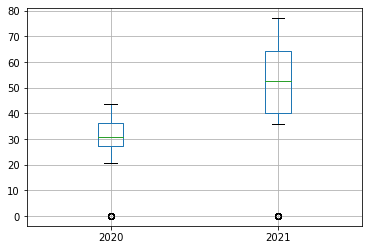

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

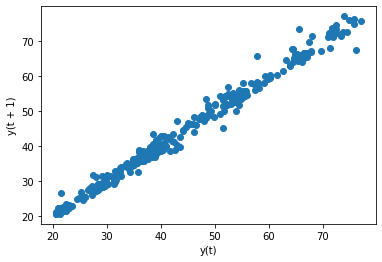

In [122]:
from pandas.plotting import lag_plot
series = df.Close
lag_plot(series)

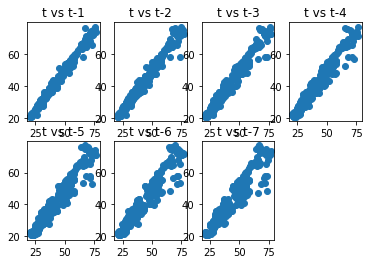

In [123]:
lags = 7
columns = [df]
for i in range(1,(lags + 1)):
    columns.append(df.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
    ax = pyplot.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    pyplot.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

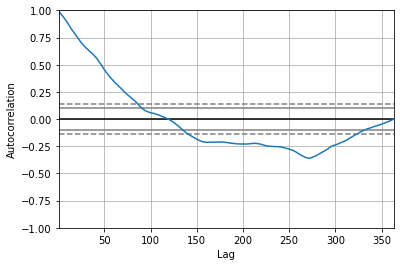

In [124]:
-
series = df.Close
autocorrelation_plot(series)
pyplot.show()

## Power transforms

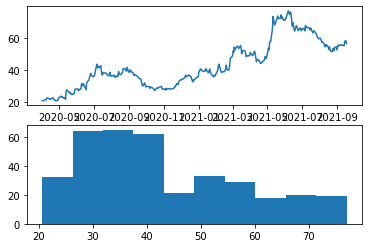

In [125]:
series = df.Close
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(series)
# histogram
pyplot.subplot(212)
pyplot.hist(series)
pyplot.show()

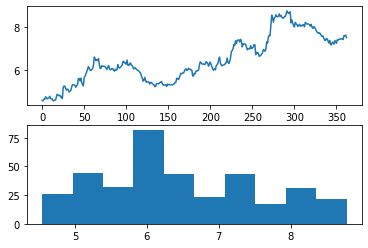

In [126]:
import numpy as np
#sqrt transforms
dataframe = pd.DataFrame(series.values)
dataframe.columns = ['close']
dataframe['close'] = np.sqrt(dataframe['close'])
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['close'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['close'])
pyplot.show()

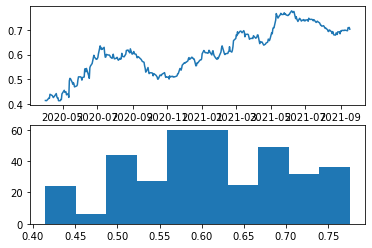

In [91]:
#log transforms
dataframe = pd.DataFrame(df.Close)
dataframe.columns = ['close']
dataframe['close'] = np.log(dataframe['close'])
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['close'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['close'])
pyplot.show()

            Close
Date             
2020-04-01  20.70
2020-04-03  20.65
2020-04-07  21.30
2020-04-08  21.25
2020-04-09  22.35
...           ...
2021-09-13  55.15
2021-09-14  58.00
2021-09-15  57.90
2021-09-16  58.20
2021-09-17  56.55

[363 rows x 1 columns]


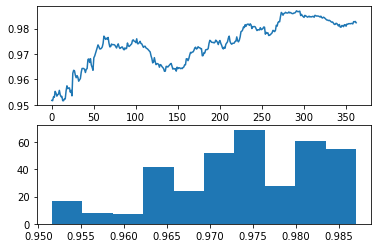

In [131]:
#Box cox 
#  lambda = -1. is a reciprocal transform.
# lambda = -0.5 is a reciprocal square root transform.
#  lambda = 0.0 is a log transform.
# lambda = 0.5 is a square root transform.
# lambda = 1.0 is no transform.
from pandas import read_csv
from pandas import DataFrame
from scipy.stats import boxcox
from matplotlib import pyplot
series = df.Close
dataframe = DataFrame(series.values)
dataframe.columns = ['close']
dataframe['close'] = boxcox(dataframe['close'], lmbda=-1)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['close'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['close'])
pyplot.show()

Lambda: -0.049232


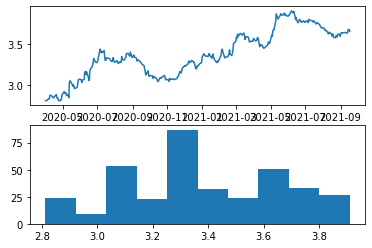

In [136]:
dataframe = DataFrame(df.Close)
dataframe.columns = ['close']
dataframe['close'], lam = boxcox(dataframe['close'])
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(dataframe['close'])
# histogram
pyplot.subplot(212)
pyplot.hist(dataframe['close'])
pyplot.show()

## smoothing

Date
2020-04-01          NaN
2020-04-03          NaN
2020-04-07    20.883333
2020-04-08    21.066667
2020-04-09    21.633333
2020-04-13    21.866667
2020-04-15    21.933333
2020-04-16    21.716667
2020-04-17    21.666667
2020-04-20    22.033333
Name: Close, dtype: float64


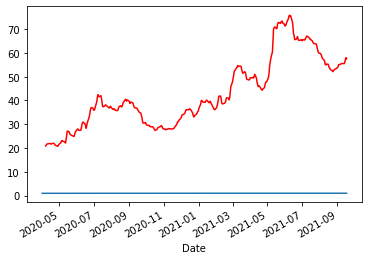

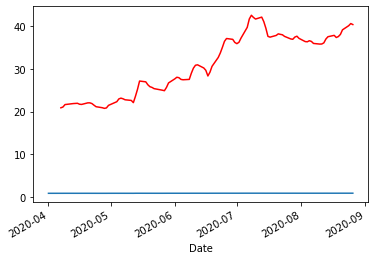

In [137]:
rolling = df.Close.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()
# zoomed plot original and transformed dataset
series[:100].plot()
rolling_mean[:100].plot(color='red')
pyplot.show()

In [141]:
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't', 't+1']
print(dataframe.head(10))

                 mean      t    t+1
Date                               
2020-04-01        NaN    NaN  20.70
2020-04-03        NaN  20.70  20.65
2020-04-07        NaN  20.65  21.30
2020-04-08        NaN  21.30  21.25
2020-04-09  20.883333  21.25  22.35
2020-04-13  21.066667  22.35  22.00
2020-04-15  21.633333  22.00  21.45
2020-04-16  21.866667  21.45  21.70
2020-04-17  21.933333  21.70  21.85
2020-04-20  21.716667  21.85  22.55


In [ ]:
from pandas import DataFrame

values = DataFrame(bheldata)
values.sort_values(by='Date')
values